In [1]:
import yfinance as yf
import numpy as np
import pandas as pd


# Download historical data for Nifty 50 from Yahoo Finance
nifty_data = yf.download('HDFCBANK.NS', start='2003-01-01', end='2025-03-19')

# Save the data to a CSV file
nifty_data.to_csv('nifty50_historical_data.csv')

# Print the first few rows of the data
print(nifty_data)


[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2003-01-01    21.990000    21.990000    21.500000    21.559999    18.422180   
2003-01-02    21.700001    21.900000    21.490000    21.834999    18.657158   
2003-01-03    21.555000    21.850000    21.500000    21.545000    18.409363   
2003-01-06    21.540001    21.600000    21.410000    21.485001    18.358099   
2003-01-07    21.500000    21.799999    21.455000    21.764999    18.597343   
...                 ...          ...          ...          ...          ...   
2024-03-27  1423.550049  1447.949951  1421.250000  1440.699951  1440.699951   
2024-03-28  1440.699951  1460.500000  1440.699951  1447.900024  1447.900024   
2024-04-01  1458.000000  1473.800049  1455.599976  1470.500000  1470.500000   
2024-04-02  1465.150024  1494.849976  1463.250000  1480.150024

In [2]:
# Calculate daily returns
nifty_data['daily_returns'] = nifty_data['Close'].pct_change()*100

mean_return = nifty_data['daily_returns'].mean()
p=mean_return*10

#Define the conditions and apply them to create 'expected_returns'
conditions = [
    (nifty_data['daily_returns'] >= p),
    (nifty_data['daily_returns'] <= -1*p),
    (np.abs(nifty_data['daily_returns']) -1*p< p)
]

choices = [1, -1, 0]

nifty_data['expected_returns'] = np.select(conditions, choices, default=0)

# Drop NaN values introduced by the calculation
nifty_data = nifty_data.dropna()

nifty_data.tail(5)
print(mean_return)

nifty_data['expected_returns'].value_counts()

0.0976250752274315


expected_returns
 0    2858
 1    1286
-1    1129
Name: count, dtype: int64

In [3]:
def calculate_additional_features(data):
    # Relative Strength Index (RSI)
    period = 14
    data['rsi'] = 100 - (100 / (1 + data['daily_returns'].rolling(window=period, min_periods=1).apply(lambda x: x[x > 0].mean(), raw=True) /
                                  data['daily_returns'].rolling(window=period, min_periods=1).apply(lambda x: x[x < 0].mean(), raw=True)))

    # Bollinger Bands
    window = 20
    data['ma'] = data['Close'].rolling(window=window).mean()
    data['std'] = data['Close'].rolling(window=window).std()
    data['upper_band'] = data['ma'] + (2 * data['std'])
    data['lower_band'] = data['ma'] - (2 * data['std'])

    # Moving Averages (5, 20, 50, 100)
    data['ma_5'] = data['Close'].rolling(window=5).mean()
    data['ma_20'] = data['Close'].rolling(window=20).mean()
    data['ma_50'] = data['Close'].rolling(window=50).mean()
    data['ma_100'] = data['Close'].rolling(window=100).mean()

    # Two Volume-based Indicators
    data['volume_ma_5'] = data['Volume'].rolling(window=5).mean()
    data['volume_ma_20'] = data['Volume'].rolling(window=20).mean()

    # Percentage Change for Last 1, 3, 5 Days
    data['pct_change_1d'] = data['Close'].pct_change(1)
    data['pct_change_3d'] = data['Close'].pct_change(3)
    data['pct_change_5d'] = data['Close'].pct_change(5)

    # High and Low Prices for Last 1, 3, 5, 8, 13, 21 Days
    periods = [1, 3, 5, 8, 13, 21]
    for period in periods:
        data[f'high_{period}d'] = data['High'].rolling(window=period).max()
        data[f'low_{period}d'] = data['Low'].rolling(window=period).min()

    # Peaks and Troughs
    data['peak'] = (data['Close'] > data['Close'].shift(1)) & (data['Close'] > data['Close'].shift(-1))
    data['trough'] = (data['Close'] < data['Close'].shift(1)) & (data['Close'] < data['Close'].shift(-1))

    return data.dropna()

# Apply the function to the existing DataFrame
nifty_data = calculate_additional_features(nifty_data)




C:\Users\HI\AppData\Local\Temp\ipykernel_9632\720433890.py:5: RuntimeWarning: Mean of empty slice.
  data['daily_returns'].rolling(window=period, min_periods=1).apply(lambda x: x[x < 0].mean(), raw=True)))
C:\Users\HI\AppData\Local\Temp\ipykernel_9632\720433890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsi'] = 100 - (100 / (1 + data['daily_returns'].rolling(window=period, min_periods=1).apply(lambda x: x[x > 0].mean(), raw=True) /
C:\Users\HI\AppData\Local\Temp\ipykernel_9632\720433890.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [4]:
def calculate_additional_features(data):
    # ... (previous code)

    # Extract additional time-based features
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['week'] = data.index.isocalendar().week  # Corrected line
    data['year'] = data.index.year
    data['quarter'] = data.index.quarter
    data['weekday'] = data.index.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)


    return data.dropna()

# Apply the function to the existing DataFrame
nifty_data = calculate_additional_features(nifty_data)


In [5]:
def detect_head_shoulder(df, window=3):
# Define the rolling window
    roll_window = window
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    # Create a boolean mask for Head and Shoulder pattern
    mask_head_shoulder = ((df['high_roll_max'] > df['High'].shift(1)) & (df['high_roll_max'] > df['High'].shift(-1)) & (df['High'] < df['High'].shift(1)) & (df['High'] < df['High'].shift(-1)))
    # Create a boolean mask for Inverse Head and Shoulder pattern
    mask_inv_head_shoulder = ((df['low_roll_min'] < df['Low'].shift(1)) & (df['low_roll_min'] < df['Low'].shift(-1)) & (df['Low'] > df['Low'].shift(1)) & (df['Low'] > df['Low'].shift(-1)))
    # Create a new column for Head and Shoulder and its inverse pattern and populate it using the boolean masks
    df['head_shoulder_pattern'] = np.nan
    df.loc[mask_head_shoulder, 'head_shoulder_pattern'] = 1
    df.loc[mask_inv_head_shoulder, 'head_shoulder_pattern'] = 2
    return df 
    # return not df['head_shoulder_pattern'].isna().any().item()

def detect_multiple_tops_bottoms(df, window=3):
# Define the rolling window
    roll_window = window
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    df['close_roll_max'] = df['Close'].rolling(window=roll_window).max()
    df['close_roll_min'] = df['Close'].rolling(window=roll_window).min()
    # Create a boolean mask for multiple top pattern
    mask_top = (df['high_roll_max'] >= df['High'].shift(1)) & (df['close_roll_max'] < df['Close'].shift(1))
    # Create a boolean mask for multiple bottom pattern
    mask_bottom = (df['low_roll_min'] <= df['Low'].shift(1)) & (df['close_roll_min'] > df['Close'].shift(1))
    # Create a new column for multiple top bottom pattern and populate it using the boolean masks
    df['multiple_top_bottom_pattern'] = np.nan
    df.loc[mask_top, 'multiple_top_bottom_pattern'] = 1
    df.loc[mask_bottom, 'multiple_top_bottom_pattern'] = 2
    return df

def calculate_support_resistance(df, window=3):
# Define the rolling window
    roll_window = window
    # Set the number of standard deviation
    std_dev = 2
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    # Calculate the mean and standard deviation for High and Low
    mean_high = df['High'].rolling(window=roll_window).mean()
    std_high = df['High'].rolling(window=roll_window).std()
    mean_low = df['Low'].rolling(window=roll_window).mean()
    std_low = df['Low'].rolling(window=roll_window).std()
    # Create a new column for support and resistance
    df['support'] = mean_low - std_dev * std_low
    df['resistance'] = mean_high + std_dev * std_high
    return df
def detect_triangle_pattern(df, window=3):
    # Define the rolling window
    roll_window = window
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    # Create a boolean mask for ascending triangle pattern
    mask_asc = (df['high_roll_max'] >= df['High'].shift(1)) & (df['low_roll_min'] <= df['Low'].shift(1)) & (df['Close'] > df['Close'].shift(1))
    # Create a boolean mask for descending triangle pattern
    mask_desc = (df['high_roll_max'] <= df['High'].shift(1)) & (df['low_roll_min'] >= df['Low'].shift(1)) & (df['Close'] < df['Close'].shift(1))
    # Create a new column for triangle pattern and populate it using the boolean masks
    df['triangle_pattern'] = np.nan
    df.loc[mask_asc, 'triangle_pattern'] = 1
    df.loc[mask_desc, 'triangle_pattern'] = 2
    return df

def detect_wedge(df, window=3):
    # Define the rolling window
    roll_window = window
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    df['trend_high'] = df['High'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
    df['trend_low'] = df['Low'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
    # Create a boolean mask for Wedge Up pattern
    mask_wedge_up = (df['high_roll_max'] >= df['High'].shift(1)) & (df['low_roll_min'] <= df['Low'].shift(1)) & (df['trend_high'] == 1) & (df['trend_low'] == 1)
    # Create a boolean mask for Wedge Down pattern
        # Create a boolean mask for Wedge Down pattern
    mask_wedge_down = (df['high_roll_max'] <= df['High'].shift(1)) & (df['low_roll_min'] >= df['Low'].shift(1)) & (df['trend_high'] == -1) & (df['trend_low'] == -1)
    # Create a new column for Wedge Up and Wedge Down pattern and populate it using the boolean masks
    df['wedge_pattern'] = np.nan
    df.loc[mask_wedge_up, 'wedge_pattern'] = 1
    df.loc[mask_wedge_down, 'wedge_pattern'] = 2
    return df
def detect_channel(df, window=3):
    # Define the rolling window
    roll_window = window
    # Define a factor to check for the range of channel
    channel_range = 0.1
    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()
    df['trend_high'] = df['High'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
    df['trend_low'] = df['Low'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
    # Create a boolean mask for Channel Up pattern
    mask_channel_up = (df['high_roll_max'] >= df['High'].shift(1)) & (df['low_roll_min'] <= df['Low'].shift(1)) & (df['high_roll_max'] - df['low_roll_min'] <= channel_range * (df['high_roll_max'] + df['low_roll_min'])/2) & (df['trend_high'] == 1) & (df['trend_low'] == 1)
    # Create a boolean mask for Channel Down pattern
    mask_channel_down = (df['high_roll_max'] <= df['High'].shift(1)) & (df['low_roll_min'] >= df['Low'].shift(1)) & (df['high_roll_max'] - df['low_roll_min'] <= channel_range * (df['high_roll_max'] + df['low_roll_min'])/2) & (df['trend_high'] == -1) & (df['trend_low'] == -1)
    # Create a new column for Channel Up and Channel Down pattern and populate it using the boolean masks
    df['channel_pattern'] = np.nan
    df.loc[mask_channel_up, 'channel_pattern'] = 1
    df.loc[mask_channel_down, 'channel_pattern'] = 2
    return df

def detect_double_top_bottom(df, window=3, threshold=0.05):
    # Define the rolling window
    roll_window = window
    # Define a threshold to check for the range of pattern
    range_threshold = threshold

    # Create a rolling window for High and Low
    df['high_roll_max'] = df['High'].rolling(window=roll_window).max()
    df['low_roll_min'] = df['Low'].rolling(window=roll_window).min()

    # Create a boolean mask for Double Top pattern
    mask_double_top = (df['high_roll_max'] >= df['High'].shift(1)) & (df['high_roll_max'] >= df['High'].shift(-1)) & (df['High'] < df['High'].shift(1)) & (df['High'] < df['High'].shift(-1)) & ((df['High'].shift(1) - df['Low'].shift(1)) <= range_threshold * (df['High'].shift(1) + df['Low'].shift(1))/2) & ((df['High'].shift(-1) - df['Low'].shift(-1)) <= range_threshold * (df['High'].shift(-1) + df['Low'].shift(-1))/2)
    # Create a boolean mask for Double Bottom pattern
    mask_double_bottom = (df['low_roll_min'] <= df['Low'].shift(1)) & (df['low_roll_min'] <= df['Low'].shift(-1)) & (df['Low'] > df['Low'].shift(1)) & (df['Low'] > df['Low'].shift(-1)) & ((df['High'].shift(1) - df['Low'].shift(1)) <= range_threshold * (df['High'].shift(1) + df['Low'].shift(1))/2) & ((df['High'].shift(-1) - df['Low'].shift(-1)) <= range_threshold * (df['High'].shift(-1) + df['Low'].shift(-1))/2)

    # Create a new column for Double Top and Double Bottom pattern and populate it using the boolean masks
    df['double_pattern'] = np.nan
    df.loc[mask_double_top, 'double_pattern'] = 1
    df.loc[mask_double_bottom, 'double_pattern'] = 2

    return df

def detect_trendline(df, window=2):
    # Define the rolling window
    roll_window = window
    # Create new columns for the linear regression slope and y-intercept
    df['slope'] = np.nan
    df['intercept'] = np.nan

    for i in range(window, len(df)):
        x = np.array(range(i-window, i))
        y = df['Close'][i-window:i]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        df.at[df.index[i], 'slope'] = m
        df.at[df.index[i], 'intercept'] = c

    # Create a boolean mask for trendline support
    mask_support = df['slope'] > 0

    # Create a boolean mask for trendline resistance
    mask_resistance = df['slope'] < 0

    # Create new columns for trendline support and resistance
    df['support'] = np.nan
    df['resistance'] = np.nan

    # Populate the new columns using the boolean masks
    df.loc[mask_support, 'support'] = df['Close'] * df['slope'] + df['intercept']
    df.loc[mask_resistance, 'resistance'] = df['Close'] * df['slope'] + df['intercept']

    return df

def find_pivots(df):
    # Calculate differences between consecutive highs and lows
    high_diffs = df['High'].diff()
    low_diffs = df['Low'].diff()

    # Find higher high
    higher_high_mask = (high_diffs > 0) & (high_diffs.shift(-1) < 0)
    
    # Find lower low
    lower_low_mask = (low_diffs < 0) & (low_diffs.shift(-1) > 0)

    # Find lower high
    lower_high_mask = (high_diffs < 0) & (high_diffs.shift(-1) > 0)

    # Find higher low
    higher_low_mask = (low_diffs > 0) & (low_diffs.shift(-1) < 0)

    # Create signals column
    df['signal'] = ''
    df.loc[higher_high_mask, 'signal'] = 1
    df.loc[lower_low_mask, 'signal'] = 2
    df.loc[lower_high_mask, 'signal'] = 3
    df.loc[higher_low_mask, 'signal'] = 4

    return df

In [6]:
nifty_data = detect_head_shoulder(nifty_data)
nifty_data = detect_channel(nifty_data)
nifty_data = detect_double_top_bottom(nifty_data)
nifty_data = detect_multiple_tops_bottoms(nifty_data)
nifty_data = detect_trendline(nifty_data)
nifty_data = detect_triangle_pattern(nifty_data)
nifty_data = detect_wedge(nifty_data)
nifty_data = find_pivots(nifty_data)

C:\Users\HI\AppData\Local\Temp\ipykernel_9632\4228246620.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['trend_high'] = df['High'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
C:\Users\HI\AppData\Local\Temp\ipykernel_9632\4228246620.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['trend_low'] = df['Low'].rolling(window=roll_window).apply(lambda x: 1 if (x[-1]-x[0])>0 else -1 if (x[-1]-x[0])<0 else 0)
C:\Users\HI\AppData\Local\Temp\ipykernel_9632\4228246620.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

nifty_data.fillna(0, inplace=True)

# Shift the 'expected_returns' column by one day to get the next day's expected return
nifty_data['next_day_expected_returns'] = nifty_data['expected_returns'].shift(-1)
nifty_data
# Drop the last row as it will have NaN in the 'next_day_expected_returns' column
nifty_data = nifty_data.dropna()

# Define features and the shifted target variable
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'daily_returns',
            'rsi', 'ma', 'std', 'upper_band', 'lower_band', 'ma_5', 'ma_20',
            'ma_50', 'ma_100', 'volume_ma_5', 'volume_ma_20', 'pct_change_1d',
            'pct_change_3d', 'pct_change_5d', 'high_1d', 'low_1d', 'high_3d',
            'low_3d', 'high_5d', 'low_5d', 'high_8d', 'low_8d', 'high_13d',
            'low_13d', 'high_21d', 'low_21d', 'peak', 'trough', 'day', 'month',
            'week', 'year', 'quarter', 'weekday', 'high_roll_max', 'low_roll_min',
            'head_shoulder_pattern', 'trend_high', 'trend_low', 'channel_pattern',
            'double_pattern', 'close_roll_max', 'close_roll_min',
            'multiple_top_bottom_pattern', 'slope', 'intercept', 'support',
            'resistance', 'triangle_pattern', 'wedge_pattern']
           

target = 'next_day_expected_returns'

# Select features and target variable
X = nifty_data[features]
y = nifty_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted values to binary (1, -1, 0)
y_pred_binary = np.round(y_pred)

# Convert predicted values to binary (1, 0, -1) based on a threshold
threshold = 0.5  # You can adjust this threshold based on your preference
y_pred_binary = np.where(y_pred > threshold, 1, np.where(y_pred < -threshold, -1, 0))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2%}')

# Display classification report
print(classification_report(y_test, y_pred_binary))


# Optionally, you can use the trained model to predict the next day's expected_returns
# For demonstration, you can use the last row of the dataset as input
next_day_features = nifty_data[features].iloc[-1].values.reshape(1, -1)
next_day_prediction = model.predict(next_day_features)
next_day_binary_prediction = np.round(next_day_prediction)



Accuracy: 52.66%
              precision    recall  f1-score   support

        -1.0       0.52      0.41      0.46       220
         0.0       0.57      0.65      0.61       580
         1.0       0.38      0.32      0.35       235

    accuracy                           0.53      1035
   macro avg       0.49      0.46      0.47      1035
weighted avg       0.52      0.53      0.52      1035



C:\Users\HI\anaconda3\envs\qi-nlp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [8]:
y_test.tail(25)

Date
2024-02-23    0.0
2024-02-26    0.0
2024-02-27    0.0
2024-02-28    0.0
2024-02-29    1.0
2024-03-01    0.0
2024-03-04    0.0
2024-03-05    0.0
2024-03-06    0.0
2024-03-07   -1.0
2024-03-11    1.0
2024-03-12    0.0
2024-03-13    0.0
2024-03-14    0.0
2024-03-15    0.0
2024-03-18    0.0
2024-03-19   -1.0
2024-03-20    1.0
2024-03-21    0.0
2024-03-22   -1.0
2024-03-26    1.0
2024-03-27    0.0
2024-03-28    1.0
2024-04-01    0.0
2024-04-02    0.0
Name: next_day_expected_returns, dtype: float64

Date
2020-01-28    0.824266
2020-01-29    0.000000
2020-01-30   -0.000000
2020-01-31   -0.020391
2020-02-03   -1.000000
                ...   
2024-03-26   -1.000000
2024-03-27    0.000000
2024-03-28    0.499762
2024-04-01    0.000000
2024-04-02    0.000000
Length: 1035, dtype: float64


C:\Users\HI\AppData\Local\Temp\ipykernel_9632\3070138778.py:28: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  limited_data = cumulative_returns.last('700d')  # You can adjust this period as needed


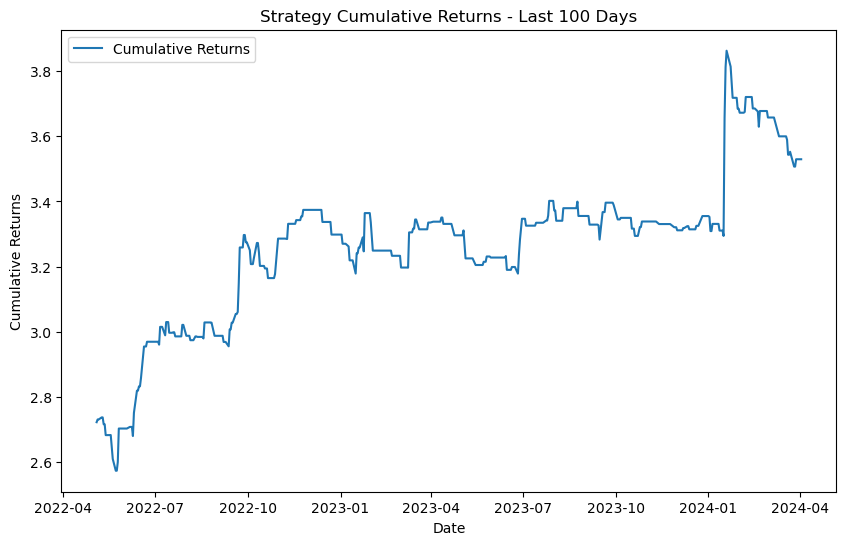

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y_test' is your Series with predictions indexed by date
predictions_series = y_test  # This is already a Series, so no need to create a DataFrame

# Convert index to datetime if it's not already, to ensure alignment
predictions_series.index = pd.to_datetime(predictions_series.index)

# Ensure nifty_data's index is also datetime for proper alignment
nifty_data.index = pd.to_datetime(nifty_data.index)

# Extend the index of nifty_data to include the next day's data for the last date in predictions_series.index
last_date = predictions_series.index[-1] + pd.Timedelta(days=1)
nifty_data = pd.concat([nifty_data, pd.DataFrame(index=[last_date])])

# Align predictions with daily returns
# Here we multiply the predictions directly with the corresponding daily returns from nifty_data
strategy_returns = predictions_series * nifty_data.loc[predictions_series.index, 'daily_returns']
strategy_returns = strategy_returns.clip(lower=-1)

print(strategy_returns)
# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns / 100).cumprod() - 1

# Plot only the last 30 days of data
limited_data = cumulative_returns.last('700d')  # You can adjust this period as needed

plt.figure(figsize=(10, 6))
plt.plot(limited_data.index, limited_data, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Cumulative Returns - Last 100 Days')
plt.legend()
plt.show()
